### Transit fitting

Here we will simulate data of a transiting planet. With the exoplanet python package we can use mathematical models describing a transit. Let's play with it:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt

In [38]:
# The light curve calculation requres an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
#u = [0, 0]
light_curve = (
    xo.LimbDarkLightCurve(*u)
    .get_light_curve(orbit=orbit, r=0.1, t=t, texp=0.02)
    .eval()
)


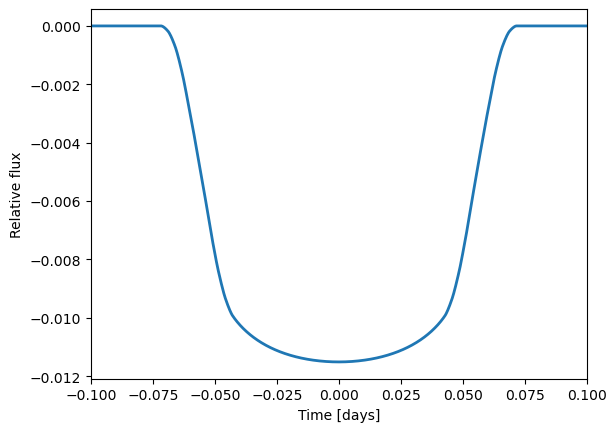

In [39]:
plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("Relative flux")
plt.xlabel("Time [days]")
_ = plt.xlim(t.min(), t.max())

To start, let's randomly sample some periods and phases and then define the time sampling:

In [40]:
np.random.seed(123)
periods = np.random.uniform(5, 20, 2)
t0s = periods* np.random.rand(2)
t = np.arange(0, 80, 0.02)
yerr = 5e-4

Define the parameters. In this model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets.

Simulate data:

In [41]:
with pm.Model() as model:
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)
    
    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)
    
    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    # The Kipping (2013) parametrisation for quadratic limb darkening parameters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    
    r = pm.Uniform(
        "r", lower=0.01, upper=0.1, shape=2, testval=np.array([0.04, 0.06])
    )
    b = xo.distributions.ImpactParameter(
        "b", ror=r, shape=2, testval=np.random.rand(2)
    )
    
    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
    
    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u[0], u[1]).get_light_curve(
        orbit=orbit, r=r, t=t
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    
    # Here we track the value of the model light curve for plotting
    pm.Deterministic("light_curves", light_curves)
    
    # On the following lines, we simulate the dataset that we will fit
    y = pmx.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))
    # End of fake data creation
    
    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)
    
    # Fit for the maximum a posteriori parameters given the simulated dataset
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [b, r, u, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 24787.977771807484 -> 24793.539425611245


Now let's plot the simulated data and the maximum a posteriori model to make sure that our initialisation looks ok. 

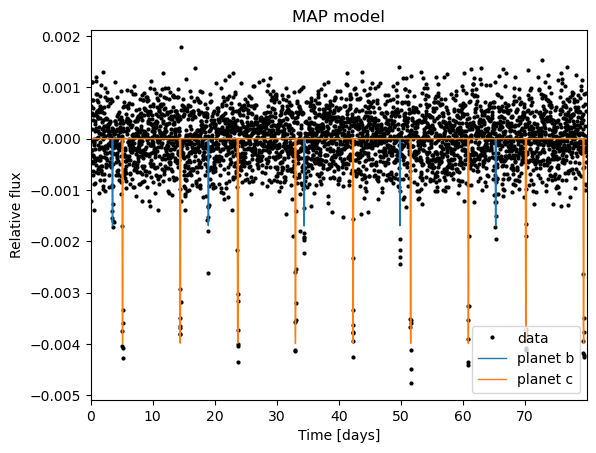

In [42]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("Relative flux")
plt.xlabel("Time [days]")
plt.legend(fontsize=10)
_ = plt.title("MAP model")

Let's sample from the posterior defined by this model. 

In [43]:
np.random.seed(42)
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln, 
        cores=2, 
        chains=2, 
        target_accept=0.9,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, r, u, logP, t0, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.


In [44]:
import arviz as az

az.summary(trace, var_names=["period", "t0", "r", "b", "u", "mean"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period[0],15.448,0.002,15.444,15.452,0.000,0.000,818.0,1227.0,1.01
period[1],9.292,0.000,9.292,9.293,0.000,0.000,2017.0,1462.0,1.00
t0[0],3.503,0.006,3.493,3.514,0.000,0.000,825.0,1354.0,1.00
t0[1],5.121,0.001,5.119,5.124,0.000,0.000,2516.0,1334.0,1.00
r[0],0.040,0.002,0.037,0.043,0.000,0.000,1018.0,1464.0,1.00
r[1],0.058,0.001,0.056,0.060,0.000,0.000,643.0,1088.0,1.00
b[0],0.669,0.046,0.577,0.738,0.002,0.001,593.0,759.0,1.01
b[1],0.401,0.039,0.333,0.467,0.001,0.001,750.0,976.0,1.00
u[0],0.365,0.207,0.008,0.711,0.006,0.004,1204.0,963.0,1.00
u[1],0.294,0.344,-0.303,0.865,0.012,0.009,743.0,1002.0,1.00


We can make plots of the model predictions for each planet

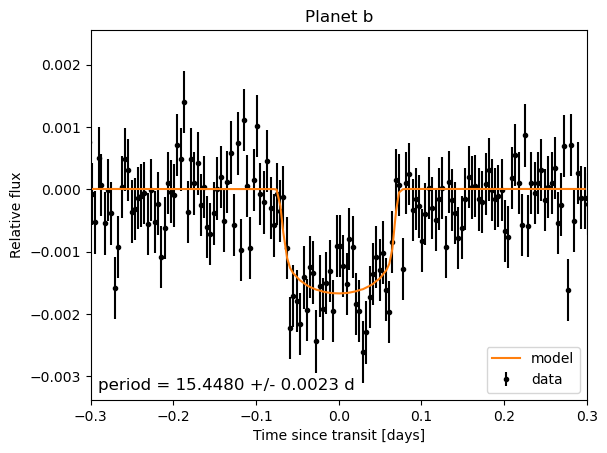

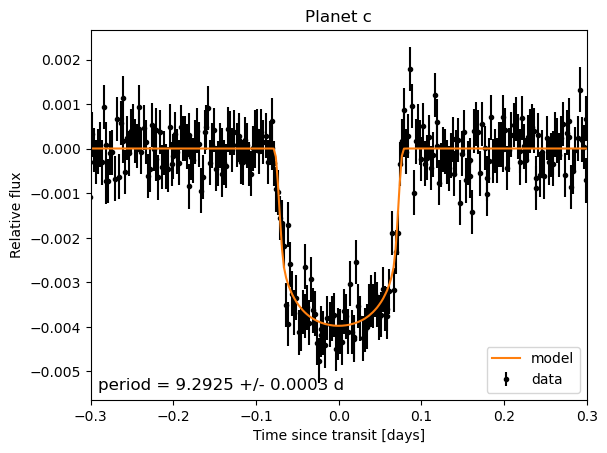

In [45]:
for n, letter in enumerate("bc"):
    plt.figure()
    
    # Get the posterior median orbital parameters
    period_trace = trace.posterior["period"].values[:, :, n]
    p = np.median(period_trace)
    t0 = np.median(trace.posterior["t0"].values[:, :, n])
    
    # Compute the median of posterior estimate of the contribution
    # from the other planet. Then we can remove this from the data
    # to plot just the planet we care about.
    lcs = trace.posterior["light_curves"].values
    other = np.median(lcs[:, :, :, (n+1)%2], axis=(0,1))
    
    # Plot the folded data
    x_fold = (t-t0+0.5*p)%p-0.5*p
    plt.errorbar(
        x_fold, y-other, yerr=yerr, fmt=".k", label="data", zorder=-1000
    )
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds]<0.3]
    pred = lcs[:, :, inds, n] + trace.posterior["mean"].values[:, :, None]
    pred = np.median(pred, axis=(0, 1))
    plt.plot(x_fold[inds], pred, color="C1", label="model")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(period_trace), np.std(period_trace)
    )
    plt.annotate(
        txt, 
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5), 
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )
    
    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("Time since transit [days]")
    plt.ylabel("Relative flux")
    plt.title("Planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

In [46]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol20, exoplanet:arviz, exoplanet:astropy13,
exoplanet:astropy18, exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3,
exoplanet:theano}.


In [47]:
print(bib.split("\n\n")[0] + "\n\n...")


@misc{exoplanet,
  author = {Daniel Foreman-Mackey and Arjun Savel and Rodrigo Luger  and
            Eric Agol and Ian Czekala and Adrian Price-Whelan and
            Christina Hedges and Emily Gilbert and Luke Bouma and Tom Barclay
            and Timothy D. Brandt},
   title = {exoplanet-dev/exoplanet v0.5.0},
   month = may,
    year = 2021,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}

...
